**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [44]:
from types import SimpleNamespace
from scipy import optimize
import random
import sympy as sm
import numpy as np
from scipy.optimize import minimize, root
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sympy import *
from test import LaborEconomicsModelClass
from test import Griewank
from test import RefinedGlobalOptimizer
from test import HairSalonOptimizer
np.random.seed(123)
random.seed(123)

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

We substitute for $C$ and $\tilde{w}$ to get the utility function: $\ln\left(\left(\kappa+\tilde{w}L\right)^{\alpha}G^{1-\alpha}\right)-\nu\frac{L}{2}^{2}$. In the LaborEconomicsModelClass we define the utility function, we then use sympy to take the derivative w.r.t. L. We then solve the FOC. We loop over $G=1$ and $G=2$ and find equivalent expressions for $L^{*}(\tilde{w})$. 

In [45]:
model = LaborEconomicsModelClass()

# Print the FOC for G = 1.0 and G = 2.0
model.print_FOC(1.0)
model.print_FOC(2.0)

# Solve the model symbolically for G = 1.0 and G = 2.0
for G in [1.0, 2.0]:
    L_star = model.solve_model_symbolically(G)
    print(f"For G = {G}, L* = {L_star}")


FOC:  1.0**(1 - alpha)*1.0**(alpha - 1)*alpha*wtilde/(L*wtilde + kappa) - L*nu
FOC:  2.0**(1 - alpha)*2.0**(alpha - 1)*alpha*wtilde/(L*wtilde + kappa) - L*nu
For G = 1.0, L* = 0.5*(-kappa*nu - sqrt(nu*(4.0*alpha*wtilde**2 + kappa**2*nu)))/(nu*wtilde)
For G = 2.0, L* = 0.5*(-kappa*nu - sqrt(nu*(4.0*alpha*wtilde**2 + kappa**2*nu)))/(nu*wtilde)


Solving the model analytically for $G=1$ and $G=2$ we find that we cannot verify that $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$. Instead we get that in both cases of $G$ the optimal labour output is $L\left(\tilde{w}^{*}\right)=\frac{-\kappa\nu-\sqrt{\nu\left(4\alpha\tilde{w}^{2}+\kappa^{2}\nu\right)}}{2\nu\tilde{w}}$

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

To illustrate how $L^{\star}(\tilde{w})$ depends on w we calcualte $L^{\star}(\tilde{w})$ for different values of w and plot the result in a line plot for both $G$'s. We see that the plots are the same for both values of $G$ which is to be expected as $G$ is not in the function for $L^{\star}(\tilde{w})$.

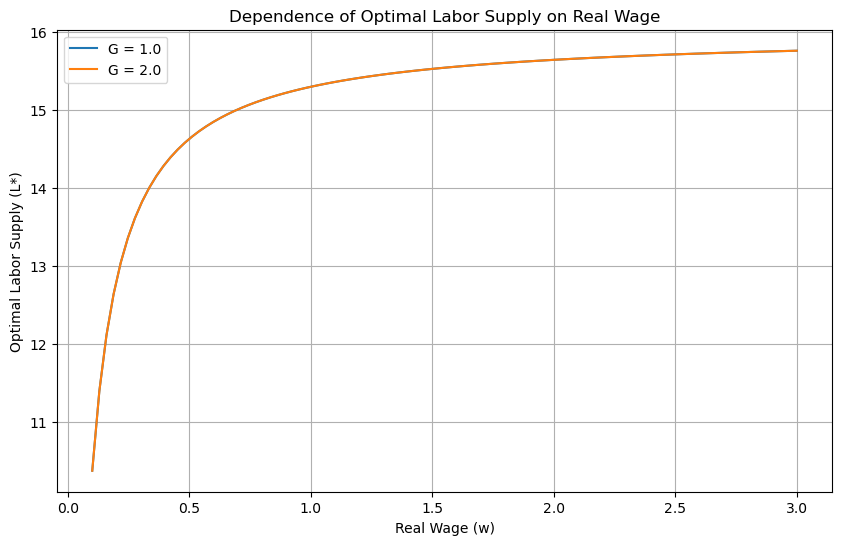

In [46]:
model = LaborEconomicsModelClass()

G_values = [1.0,2.0]
w_values = np.linspace(0.1, 3, 100)

# Calculate and plot the optimal labor supply choice for different values of w and G
plt.figure(figsize=(10, 6))
for G in G_values:
    tilde_w_values = (1 - model.val.tau) * w_values
    L_star_values = model.L_star(tilde_w_values)
    plt.plot(w_values, L_star_values, label=f'G = {G}')

plt.xlabel('Real Wage (w)')
plt.ylabel('Optimal Labor Supply (L*)')
plt.title('Dependence of Optimal Labor Supply on Real Wage')
plt.legend()
plt.grid(True)
plt.show()

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


To do this we define a grid of $\tau$-values calculating $L$, $G$ and worker utility for each $\tau$ in the range. 

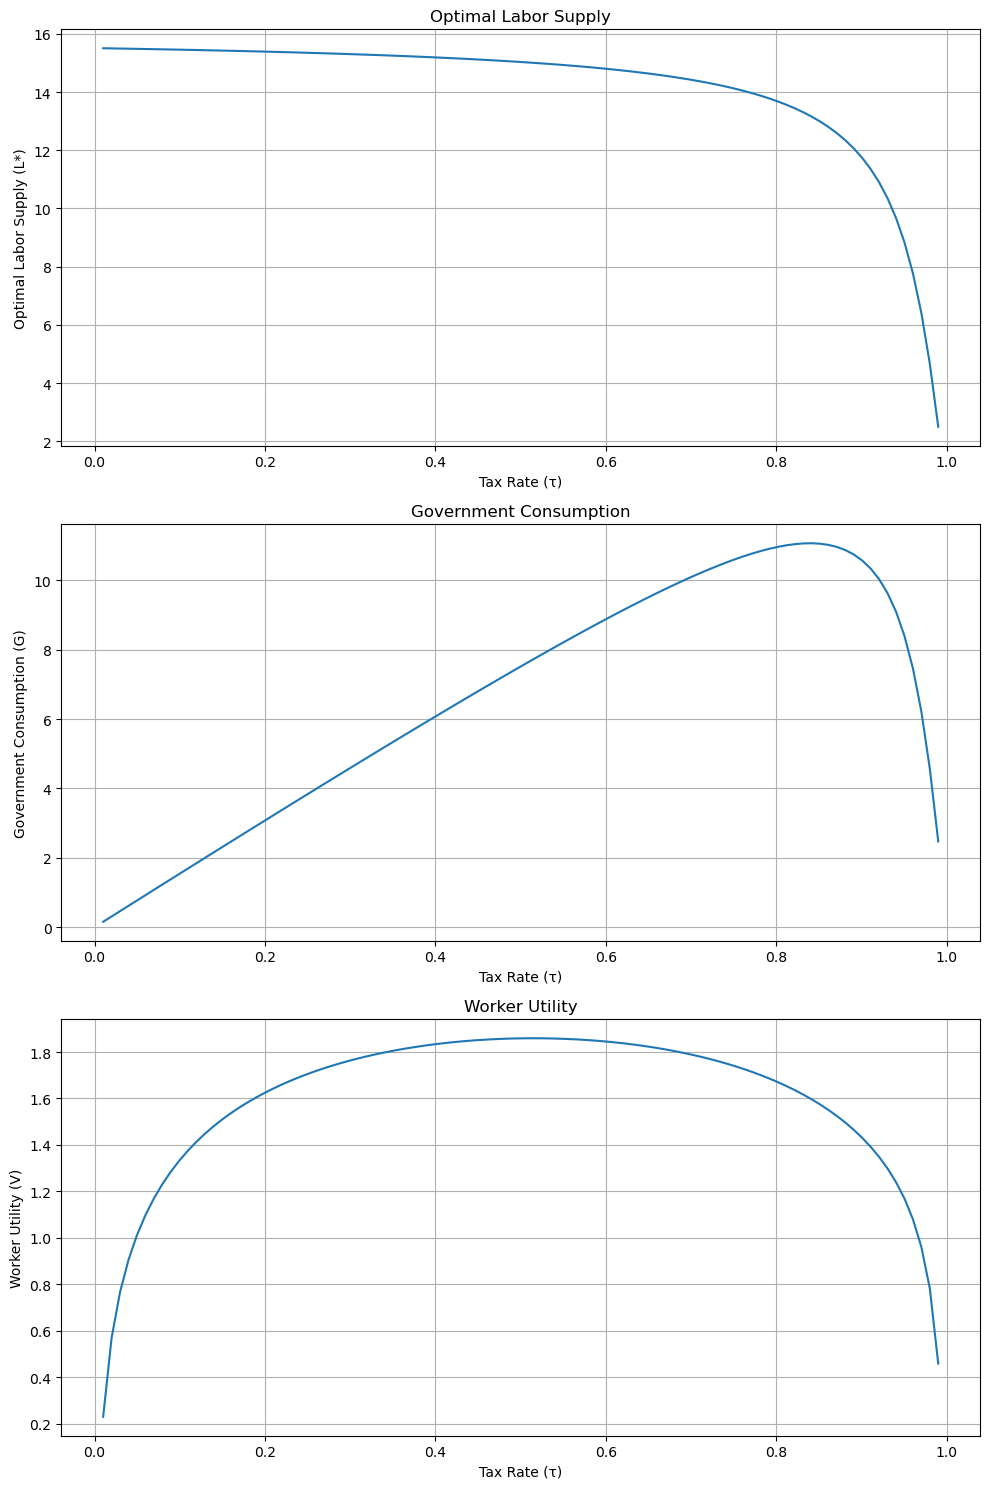

In [47]:
model = LaborEconomicsModelClass()

# grid of tax rate values
tau_values = np.linspace(0.01, 0.99, 100)

# optimal labor supply, government consumption, and worker utility for each tax rate
L_values = [model.L_star((1 - tau) * model.val.w) for tau in tau_values]
G_values = [model.G(tau) for tau in tau_values]
V_values = [model.V(tau) for tau in tau_values]

# plot the results
fig, axs = plt.subplots(3, figsize=(10, 15))

axs[0].plot(tau_values, L_values)
axs[0].set_title('Optimal Labor Supply')
axs[0].set_xlabel('Tax Rate (τ)')
axs[0].set_ylabel('Optimal Labor Supply (L*)')
axs[0].grid(True)

axs[1].plot(tau_values, G_values)
axs[1].set_title('Government Consumption')
axs[1].set_xlabel('Tax Rate (τ)')
axs[1].set_ylabel('Government Consumption (G)')
axs[1].grid(True)

axs[2].plot(tau_values, V_values)
axs[2].set_title('Worker Utility')
axs[2].set_xlabel('Tax Rate (τ)')
axs[2].set_ylabel('Worker Utility (V)')
axs[2].grid(True)

plt.tight_layout()
plt.show()


We see that optimal labor supply is converges to zero as $\tau$ goes to 1. Goverment consumption is steadily increasing until a maximum point. After this point it is decreasing indicating that it is possible to maximize government consumption by choosing $\tau$. Worker utility is increasing until a maximum and decreasing thereafter. This represents the tradeoff between private and government utility indicating that it is possible to maximize worker utility by setting a optimal tax rate.



**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

To find the optimal tax rate we minimize negative utility w.r.t $\tau$. We set initial guess at $\tau = 0.5$. Thereafter we plot a vertical line representing the optimal value in the plot from before.

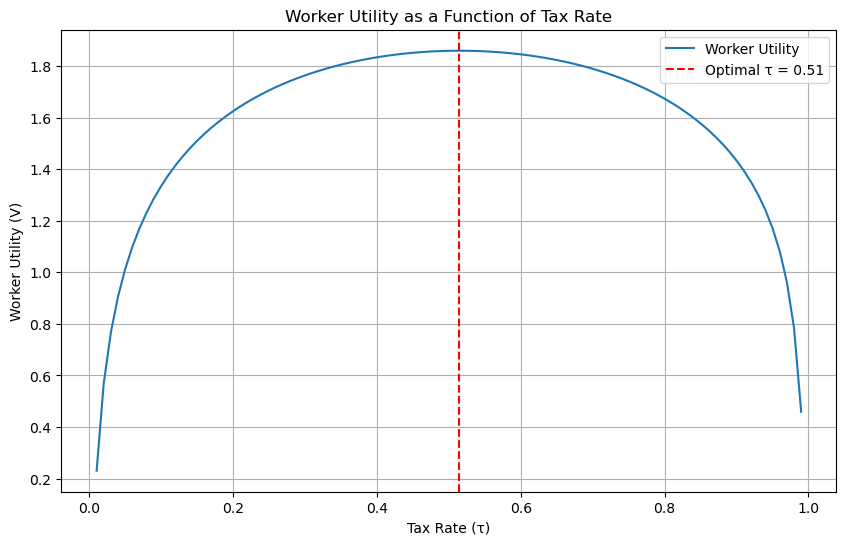

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

model = LaborEconomicsModelClass()

# defining the negative of the utility function to minimize
def neg_V(tau):
    return -model.V(tau)

# solving for optimal tax rate
result = minimize(neg_V, [0.5], bounds=[(0.01, 0.99)])
optimal_tau = result.x[0]

#grid of tax rate values
tau_values = np.linspace(0.01, 0.99, 100)

# worker utility for each tax rate
V_values = [model.V(tau) for tau in tau_values]

plt.figure(figsize=(10, 6))
plt.plot(tau_values, V_values, label='Worker Utility')
plt.axvline(optimal_tau, color='red', linestyle='--', label=f'Optimal τ = {optimal_tau:.2f}')
plt.title('Worker Utility as a Function of Tax Rate')
plt.xlabel('Tax Rate (τ)')
plt.ylabel('Worker Utility (V)')
plt.legend()
plt.grid(True)
plt.show()

We find that the optimal tax rate maximizing worker utility is at 51%

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

To find the optimal $G$ we first need to define the new utility and the government budget constraint. We define a algorithm that initially sets $G=1$ and then minimizes negative utility to derive $L^{\star}(\tilde{w})$. Thereafter we use the condition to find the value of $G$ that balances the governments budget constraint given by $G = \tau w L^{\star}((1-\tau)w,G)$. 

NB: We wanted to use use the model class that we have used up until now but had some error problems that we were unable to fix. 

In [49]:
from scipy.optimize import minimize, root
alpha = 0.5
kappa = 1.0
nu = 1/(2*16**2)
w = 1.0
tau = 0.51
parameters_sets = [(1.001, 1.001, 1.0), (1.5, 1.5, 1.0)]

# Define utility function
def utility(L, w, tau, G, alpha, kappa, nu, sigma, rho, epsilon):
    C = kappa + (1 - tau)*w*L
    U = ((alpha * C**((sigma-1)/sigma) + (1-alpha) * G**((sigma-1)/sigma))**(sigma/(sigma-1)))**(1-rho)/(1-rho) - nu * L**(1+epsilon) / (1+epsilon)
    return -U 

# Define G condition function
def G_condition(G, w, tau, L):
    return G - tau * w * L

# Iterate over both sets of parameters
for i, (sigma, rho, epsilon) in enumerate(parameters_sets, 1):
    # Initial guess
    G = 1
    
    # First step: solve the worker problem for a given G and tau
    result = minimize(utility, x0=1, args=(w, tau, G, alpha, kappa, nu, sigma, rho, epsilon), bounds=[(0, 24)])
    if result.success:
        L_star = result.x[0]
        print('Set', i, ':', (sigma, rho, epsilon))
        print('Optimal L*:', f'{L_star:.2f}')

        # Second step: find the correct G based on the condition
        result_G = root(G_condition, x0=1, args=(w, tau, L_star))
        G_star = result_G.x[0]
        print('Optimal G*:', f'{G_star:.2f}')
    print()



Set 1 : (1.001, 1.001, 1.0)
Optimal L*: 15.01
Optimal G*: 7.66

Set 2 : (1.5, 1.5, 1.0)
Optimal L*: 12.79
Optimal G*: 6.52



**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

We use the solve_model_numerically class in the LaborEconomicsModelClass to loop over a range of taxes (from 1 to 100%) at 100 evenly spaced intervals. For each tax rate it finds the optimal labor and the corresponding government expenditure. If the calculated utility is higher than the previous calculated utility it saves the utility. The process is repeated for each tax rate for each of the sets of parameters until we get the optimal tax rates. 

In [50]:
model = LaborEconomicsModelClass()
parameters_sets = [(1.001, 1.001, 1.0), (1.5, 1.5, 1.0)]
results = model.solve_model_numerically(parameters_sets)
for result in results:
    print(f'Set {result["Set"]}: {result["Parameters"]}')
    print('Optimal tau*:', f'{result["Optimal tau"]:.2f}')
    print('Optimal L*:', f'{result["Optimal L"]:.2f}')
    print('Optimal G*:', f'{result["Optimal G"]:.2f}')

Set 1: (1.001, 1.001, 1.0)
Optimal tau*: 0.52
Optimal L*: 15.00
Optimal G*: 7.73
Set 2: (1.5, 1.5, 1.0)
Optimal tau*: 0.55
Optimal L*: 12.81
Optimal G*: 6.99


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

Firstly we insert the baseline values of $\eta, \nu$ and $\kappa$ to get the $\ell_t$ that maximizes profits for the two values of $\kappa$.

In [51]:
# Inserting the baseline parameter values into the given l_t function

kappa_t_values = [1.0, 2.0]
w = 1
eta = 0.5

for kappa_t in kappa_t_values:
    l_t = (kappa_t*(1 - eta)/w)**(1/eta)
    print(f"For \kappa_t = {kappa_t}, l_t = {l_t}")

For \kappa_t = 1.0, l_t = 0.25
For \kappa_t = 2.0, l_t = 1.0


Now we solve it $\ell_t$ ourselves with the baseline values and compare the optimal $\ell_t$ results, to verify that the given equation maximizes profits.

In [52]:
# Symbols and parameters
l_t = sm.symbols('l_t')
kappa_t = sm.symbols('kappa_t')
w_value = 1
eta_value = 0.5

# Profit function
profit = kappa_t * l_t ** (1 - eta_value) - w_value * l_t

# Taking the derivative of the profit function wrt l_t
profit_derivative = sm.diff(profit, l_t)

# Solving the derivative = 0 for l_t
optimal_l_t = sm.solve(profit_derivative, l_t)

# Printing the symbolic solution for optimal l_t
print("Optimal l_t:")
for solution in optimal_l_t:
    print(f"l_t = {solution}")

# Evaluating optimal l_t for given kappa values
kappa_values = [1.0, 2.0]
for kappa in kappa_values:
    print(f"For kappa = {kappa}, optimal l_t = {solution.subs(kappa_t, kappa):.2f}")

Optimal l_t:
l_t = 0.25*kappa_t**2
For kappa = 1.0, optimal l_t = 0.25
For kappa = 2.0, optimal l_t = 1.00


We see above that our results is equal to the results of the given equation for $\ell_t$ and we can therefore verify that this maximizes profits for $\kappa \in \{1.0,2.0\}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

We use the Calculate_H function in the HairSalonOptimizer class to compute the average expected value of running the salon over T periods. We do this by running it K number of times computing the profits in each period. We then find the ex ante expected value by summing and dividing by K

In [53]:
rho = 0.9
iota = 0.01
sigma_epsilon = 0.1
R = (1 + 0.01) ** (1 / 12)
K = 10000
T = 120

optimizer = HairSalonOptimizer(rho, iota, sigma_epsilon, R, eta, w, K, T)
H = optimizer.calculate_H()
print(f"The value of the salon H is {H:.2f}.")

The value of the salon H is 27.74.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

We continue in the same style of code, with the addition of policies:

To incorporate the policy we use the calculate_H_with_policy function from the HairSalonOptimizer class. This is essentially the same as the calculate_H class. The main difference is that we use a if statement to append either $l^{*}_{t}$ or $l_{t-1}$ depending on the condition given by the policy. 

In [54]:
Delta = 0.05
H_new = optimizer.calculate_H_with_policy(Delta)
print(f"The value of the salon H under the new policy is {H_new:.2f}.")

The value of the salon H under the new policy is 28.42.


Hence, we have that the value increases under the new policy.

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

To do this we use the find_optimal_delta function in the HairSalonOptimizer class. It creates a loop that runs the calculate_H_with_policy for different $\Delta$. It then uses numpy to find the largest values of H for given $\Delta$ in the index and retrieves both variables. Thereafter we use the plot_H_vs_Delta function from the same class to plot H against $\Delta$. 

In [55]:
delta_values = np.linspace(0.01, 0.2, 20)
max_Delta, max_H, H_values = optimizer.find_optimal_delta(delta_values)
print(f"The maximum value of H is {max_H:.2f} and it occurs at Delta = {max_Delta:.2f}.")
optimizer.plot_H_vs_delta(delta_values, H_values, max_Delta, max_H)

KeyboardInterrupt: 

This is given our seed number, had we chosen another seed we could have ended up with another result.


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



Instead of adjusting the amount of staff in the salon by current optimal labor, the hair salon owner could incoporate the future expected optimal labor in their decision making. The decision on labour units would look like this:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_{t+1}^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$


By using the expected $\kappa_{t+1}$ to calculate $\ell_{t+1}^*$ (the optimal staffing level for the next period), we are trying to anticipate the demand changes by making labour decisions in advance. This might be useful as labor adjustments might be sticky. Making decisions in advance may help avoid unnecessary adjustments to the labour.

The expected $\ell_{t+1}$ can be derived from the original optimal staffing formula $\ell_{t} = ((1-\eta)\kappa_{t}/w)^{1/\eta}$. Here, $\kappa_{t}$ represents the current period's demand shock. However, we want to anticipate the next period's demand, so we replace $\kappa_{t}$ with the expected future demand $\kappa_{t+1}$, resulting in the following formula: 

$E[\ell_{t+1}^*] = ((1-\eta)E[\kappa_{t+1}]/w)^{1/\eta}$.

The expected $\kappa_{t+1}$ is calculated based on an AR(1) process, which means that the demand shock in period $t+1$ is expected to be a function of the demand shock in period $t$ and a random error term. The formula for the AR(1) process is $\kappa_{t+1} = \rho \kappa_{t} + \epsilon_{t+1}$, where $\rho$ is the autocorrelation of the demand shock and $\epsilon_{t+1}$ is the random error term. Taking expectations on both sides gives $E[\kappa_{t+1}] = \rho \kappa_{t}$, because the expectation of $\epsilon_{t+1}$ is zero.

Therefore, the expected optimal staffing level for the next period is given by:

$E[\ell_{t+1}^*] = ((1-\eta)\rho \kappa_{t}/w)^{1/\eta}$.

To see if the new policy makes a difference we calculate the value of the salon had they incorporated the new policy. We find that the value of the hair salon ex post is lower than if they had kept the old policy.

The code uses the same approach as calculate_H_with policy but replaces $\ell_{t}^*$ with $E[\ell_{t+1}^*]$

In [58]:
rho = 0.9
iota = 0.01
sigma_epsilon = 0.1
R = (1 + 0.01) ** (1 / 12)
K = 10000
T = 120
epsilon_values = [np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon, size=T) for _ in range(K)]

def calculate_H_alternative():
    total_value = 0
    for k in range(K):
        epsilon = epsilon_values[k]
        kappa = np.empty(T)
        kappa[0] = np.exp(rho*np.log(1) + epsilon[0])
        l_last = 0
        l = []
        for t in range(T):
            if t > 0:
                kappa[t] = np.exp(rho*np.log(kappa[t-1]) + epsilon[t])
            expected_kappa_next = rho * kappa[t] if t < T - 1 else kappa[t]
            l_star_next = ((1-eta)*expected_kappa_next/w)**(1/eta)
            if abs(l_last - l_star_next) > Delta:
                l.append(((1-eta)*kappa[t]/w)**(1/eta))
            else:
                l.append(l_last)
            l_last = l[-1]
        h = np.sum([(kappa[t]*l[t]**(1-eta) - w*l[t] - iota*(l[t] != l[t-1]))*R**(-t) for t in range(T)])
        total_value += h
    return total_value / K

H_alternative = calculate_H_alternative()
print(f"The value of the salon H under the alternative policy is {H_alternative:.2f}.")


The value of the salon H under the alternative policy is 28.23.


## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In the RefinedGlobalOptimizer class we define the refined global optimizer with multi-start as proposed in the description of the assignment. We run it for $\underline{K}=10$ and $\underline{K}=100$ and save convergence time as number of iterations before break and evaluation by calling the reulst to the Griewank function. Afterwards we plot how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$ for the two starting iteration values.

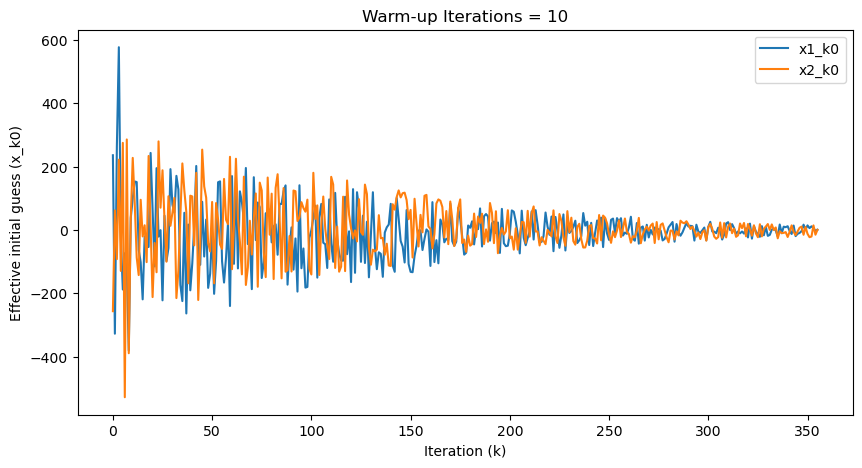

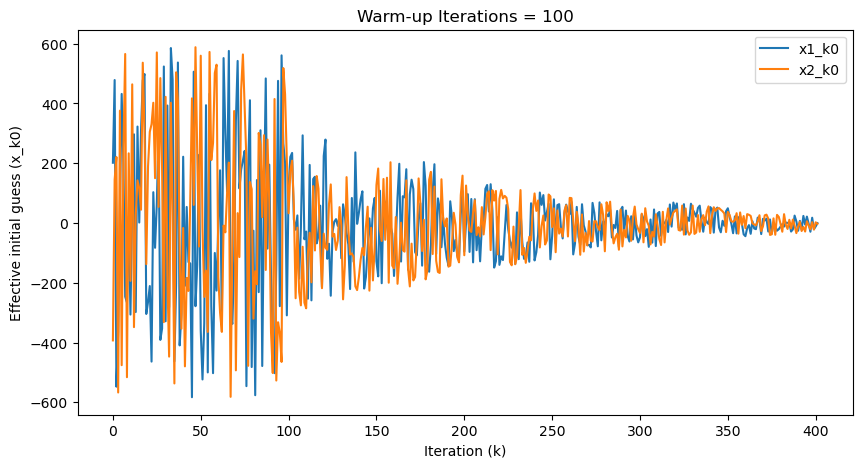

Convergence iterations for warm-up iterations 10 and 100:  [356, 402]
Accuracy measure for warm-up iterations 10 and 100:  [0.0, 0.0]
The final result is:  [-8.69461262e-09 -3.23826545e-09]
The corresponding function value is:  0.0


In [ ]:
np.random.seed(123)
# 1: Choosing bounds and setting tolerance
bounds = np.array([[-600, 600], [-600, 600]])
tolerance = 1e-8
# 2: Choosing maximum number of iterations
max_iters = 1000

warm_up_iters_list = [10, 100]
convergence_iters = []
accuracy_measure = []

for warm_up_iters in warm_up_iters_list:
    # Create an instance of Griewank and RefinedGlobalOptimizer
    griewank = Griewank()
    optimizer = RefinedGlobalOptimizer(griewank, bounds, tolerance, warm_up_iters, max_iters)

    # Perform optimization
    result = optimizer.optimize()
    convergence_iters.append(len(optimizer.x_k0_values))  # store the number of iterations
    accuracy_measure.append(griewank.evaluate(result))   # store the final accuracy measure

    # Plot effective initial guesses
    x_k0_values = np.array(optimizer.x_k0_values)
    plt.figure(figsize=(10, 5))
    plt.plot(x_k0_values[:, 0], label='x1_k0')
    plt.plot(x_k0_values[:, 1], label='x2_k0')
    plt.xlabel('Iteration (k)')
    plt.ylabel('Effective initial guess (x_k0)')
    plt.title(f'Warm-up Iterations = {warm_up_iters}')
    plt.legend()
    plt.show()

print("Convergence iterations for warm-up iterations 10 and 100: ", convergence_iters)
print("Accuracy measure for warm-up iterations 10 and 100: ", accuracy_measure)
print("The final result is: ", result)
print("The corresponding function value is: ", griewank.evaluate(result))


**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

We see that initial iterations of 10 uses 356 iterations until the tolerance condition is met, while initial iterations of 100 uses 402 iterations before the condition is met. This however, could be a product of chance and for this reason we can simulate by Monte Carlo to find the mean number of iterations for each value of $\underline{K}$ by testing the optimizer 50 times.

In [ ]:
np.random.seed(123)
# Define your bounds and parameters
bounds = np.array([[-600, 600], [-600, 600]])
tolerance = 1e-8
warm_up_iters_list = [10, 100]
max_iters = 1000
num_sims = 50 

# Create an instance of Griewank and RefinedGlobalOptimizer
griewank = Griewank()
optimizer = RefinedGlobalOptimizer(griewank, bounds, tolerance, warm_up_iters, max_iters)

mean_convergence_iters = []
mean_accuracy_measure = []

for warm_up_iters in warm_up_iters_list:
    all_convergence_iters = []
    all_accuracy_measures = []

    for sim in range(num_sims):
        optimizer.set_warm_up_iters(warm_up_iters) # Setting warm-up iterations
        result = optimizer.optimize()
        all_convergence_iters.append(len(optimizer.x_k0_values))
        all_accuracy_measures.append(np.abs(griewank.evaluate(result)))

    mean_convergence_iters.append(np.mean(all_convergence_iters))
    mean_accuracy_measure.append(np.mean(all_accuracy_measures))

print("Mean convergence iterations for warm-up iterations 10 and 100: ", mean_convergence_iters)
print("Mean accuracy measure for warm-up iterations 10 and 100: ", mean_accuracy_measure)

Mean convergence iterations for warm-up iterations 10 and 100:  [322.46, 388.06]
Mean accuracy measure for warm-up iterations 10 and 100:  [5.10702591327572e-17, 3.7747582837255325e-17]


With a mean convergence time of 322.46 for $\underline{K}=10$ versus 388.06 for $\underline{K}=100$ and with similar acuracies we are confident that it is not a great idea to use $\underline{K}=100$ over $\underline{K}=10$.